In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import h5py

/home/fabiane/anaconda2/envs/mort1/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/fabiane/anaconda2/envs/mort1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, random_split

# sklearn functions
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, KFold, GroupShuffleSplit

# load functions from nitorch
sys.path.insert(0,"/analysis/fabiane/phd/nitorch/")
from nitorch.data import load_nifti
from nitorch.transforms import  ToTensor, SagittalTranslate, SagittalFlip, \
                                AxialTranslate, normalization_factors, Normalize, \
                                IntensityRescale
from nitorch.callbacks import EarlyStopping, ModelCheckpoint
from nitorch.trainer import Trainer
from nitorch.initialization import weights_init
from nitorch.metrics import balanced_accuracy, sensitivity, specificity
from nitorch.utils import count_parameters

In [5]:
torch.__version__

'1.0.0'

In [6]:
gpu = 5
multi_gpus = None #[0, 1, 2]
b = 8
zero_one_normalize = False
dtype = np.float64

In [7]:
# load mask
mask = None

In [8]:
table = "/ritter/share/projects/UKbiobank/Eitel_ICD/tables/participants_transMRI_T1-ICD10_G_binary-under.csv"

In [9]:
# load dataset and show first 5 rows
df = pd.read_csv(table)
df.head()

,Unnamed: 0,PTID,file_path,T2,Encoded anonymised participant ID,T1 structural brain images - NIFTI Index: 2.0,T2 FLAIR structural brain images - NIFTI Index: 2.0,Functional brain images - task - NIFTI Index: 2.0,Sex,ICD10_F_cat,...,Illness2Years2,MoodSwings_diff,Sensitivity_diff,Nervous_diff,Worrier_diff,TenseHighlyStung_diff,Loneliness_diff,RiskTaking_diff,Happiness_diff,FamilyRelation_diff
0,0,1100042,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1100042,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,0YY,0YY,1NN,0YY,1NN,1NN,1NN,9Na,9Na
1,1,1100675,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1100675,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,1NN,9else,1NN,0YY,9else,1NN,9else,9Na,9Na
2,2,1180478,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1180478,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,0YY,0YY,1NN,2YN,0YY,1NN,0YY,9Na,9Na
3,3,1112124,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1112124,20252_2_0,20253_2_0,20249_2_0,Male,[],...,0None,9else,0YY,0YY,0YY,9else,1NN,1NN,9Na,9Na
4,4,1148079,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1148079,20252_2_0,20253_2_0,20249_2_0,Female,[],...,3SitY,3NY,0YY,3NY,0YY,3NY,1NN,1NN,9Na,9Na


In [10]:
# shuffle the dataset
df = df.sample(frac=0.2, random_state=23)
df.head()

,Unnamed: 0,PTID,file_path,T2,Encoded anonymised participant ID,T1 structural brain images - NIFTI Index: 2.0,T2 FLAIR structural brain images - NIFTI Index: 2.0,Functional brain images - task - NIFTI Index: 2.0,Sex,ICD10_F_cat,...,Illness2Years2,MoodSwings_diff,Sensitivity_diff,Nervous_diff,Worrier_diff,TenseHighlyStung_diff,Loneliness_diff,RiskTaking_diff,Happiness_diff,FamilyRelation_diff
791,791,1109592,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1109592,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,1NN,3NY,1NN,0YY,1NN,1NN,3NY,MH.VH,VH.VH
1705,1705,1197086,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1197086,20252_2_0,20253_2_0,20249_2_0,Male,[],...,0None,0YY,0YY,9else,2YN,3NY,0YY,1NN,9Na,9Na
167,167,1092621,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1092621,20252_2_0,20253_2_0,20249_2_0,Female,[],...,"4SitR,5DocR",2YN,1NN,1NN,1NN,1NN,3NY,1NN,9Na,9Na
331,331,1037619,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1037619,20252_2_0,20253_2_0,20249_2_0,Male,[],...,0None,2YN,0YY,3NY,3NY,1NN,1NN,0YY,9Na,9Na
651,651,1161652,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1161652,20252_2_0,20253_2_0,20249_2_0,Male,[],...,0None,3NY,3NY,1NN,0YY,1NN,3NY,2YN,9Na,9Na


In [22]:
class UKBGDataset(Dataset):
    def __init__(self, dataframe, transform=None, mask=None, z_factor=None):
        self.df = dataframe
        self.transform = transform
        self.mask = mask
        self.z_factor = z_factor
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if isinstance(idx, torch.FloatTensor):
            idx = idx.item()
        idx = int(idx)
        
        path = self.df.iloc[idx]['file_path']
        path = path.replace("/analysis/ritter", "/ritter/share")
        image = load_nifti(path, mask=self.mask, z_factor=self.z_factor)
        
        # normalize by max
        image /= np.max(image)
        
        label = self.df.iloc[idx]['Sex']
        label = torch.FloatTensor([int(label == "Male")])
        
        if self.transform:
            image = self.transform(image)
        
        sample = {
            "image" : image,
            "label" : label
         }
        return sample

In [23]:
augmentations = [SagittalFlip(), SagittalTranslate(dist=(-2, 3))]

In [24]:
intensity = IntensityRescale(masked=False)
input_trans = transforms.Compose(augmentations + [intensity, ToTensor()])

In [25]:
ukb_data = UKBGDataset(df, transform=input_trans, mask=mask)

In [26]:
len(ukb_data)

371

In [27]:
# split train/test
train_df = df.sample(frac=0.8, random_state=32)
test_df = df[~df["PTID"].isin(train_df["PTID"])]

In [28]:
sample = ukb_data[3]
img = sample["image"]

In [29]:
img.shape

torch.Size([1, 182, 218, 182])

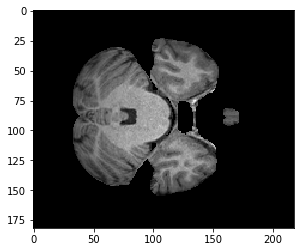

In [30]:
plt.imshow(img[0][:,:,40], cmap='gray')

In [31]:
sample["label"]

tensor([1.])

# Define the classifier

In [32]:
class SixtyFourNet(nn.Module):
    def __init__(self, drp_rate=0.3):
        super(SixtyFourNet, self).__init__()
        self.drp_rate = drp_rate
        self.drop = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 8, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(8, 16, kernel_size=3, stride=1, padding=0)
        self.pool_2 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_3 = nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=0)
        self.Conv_4 = nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=0)
        self.pool_4 = nn.MaxPool3d(kernel_size=4, stride=2, padding=0)
        self.Conv_5 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_5 = nn.MaxPool3d(kernel_size=4, stride=2, padding=0)

        self.classifier_scratch = nn.Sequential(
            nn.Linear(11200, 100),
            nn.Linear(100, 1)
        )

    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = self.drop(self.pool_1(x))
        x = F.elu(self.Conv_2(h))
        if print_size:
            print(x.shape)
        h = self.drop(self.pool_2(x))
        x = F.elu(self.Conv_3(h))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_4(x))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_5(x))
        if print_size:
            print(x.shape)
        h = self.drop(self.pool_5(x)) 
        return h

    def forward(self, x):
        print_size = False
        x = self.encode(x, print_size=print_size)
        x = self.flatten(x)
        x = self.classifier_scratch(x)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [33]:
if multi_gpus is None:
    net = SixtyFourNet().cuda(gpu)
else:
    net = torch.nn.DataParallel(SixtyFourNet(), device_ids=multi_gpus).cuda(gpu)

In [34]:
print("Trainable model parameters: {}".format(count_parameters(net)))

Trainable model parameters: 1303769


# Training

In [25]:
def run(
    net,
    data,
    shape,
    callbacks=[],
    augmentations=[],
    masked=False,
    metrics=[],
    k_folds=None,
    b=4,
    num_epochs=35,
    retain_metric=None
):      
   
    fold_metric = []
    best_metric = []
    models = []
    fold = 0
    initial_prepend = None
    
    for trial in range(10):
        print("Starting trial {}".format(trial))

        # add current fold number to model checkpoint path
        if callbacks is not None:
            for idx, callback in enumerate(callbacks):
                if isinstance(callback, ModelCheckpoint):
                    if initial_prepend is None:
                        initial_prepend = callbacks[idx].prepend
                    callbacks[idx].prepend = initial_prepend + "cv_fold_{}_".format(fold)
        fold += 1

        # restart model
        del net
        net = SixtyFourNet().cuda(gpu)
        
        # reset hyperparameters
        lr = 1e-4
        wd = 1e-4
        criterion = nn.BCEWithLogitsLoss().cuda(gpu)
        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

         # split train/validation
        train_df = data.sample(frac=0.8, random_state=32)
        val_df = data[~data["PTID"].isin(train_df["PTID"])]

        if zero_one_normalize:
            intensity = IntensityRescale()
            ukb_data_train = UKBGDataset(train_df, transform=transforms.Compose(augmentations + [intensity, ToTensor()]), mask=mask)
            ukb_data_val = UKBGDataset(val_df, transform=transforms.Compose([intensity, ToTensor()]), mask=mask)
        else:
            ukb_data_train = UKBGDataset(train_df, transform=transforms.Compose(augmentations + [ToTensor()]), mask=mask)
            ukb_data_val = UKBGDataset(val_df, transform=transforms.Compose([ToTensor()]), mask=mask)
        
        train_loader = DataLoader(
            ukb_data_train, batch_size=b, shuffle=True, num_workers=4
        )

        val_loader = DataLoader(
            ukb_data_val, batch_size=2, shuffle=True, num_workers=2
        )

        trainer = Trainer(
            net,
            criterion,
            optimizer,
            metrics=metrics,
            callbacks=callbacks,
            device=gpu
        )
        # train model and store results
        net, report = trainer.train_model(
            train_loader,
            val_loader,
            num_epochs=num_epochs,
            show_train_steps=20,
            show_validation_epochs=1,
        )
        # append validation score of the retain metric
        if isinstance(retain_metric, str):
            fold_metric.append(report["val_metrics"][retain_metric][-1])
            best_metric.append(np.max(report["val_metrics"][retain_metric]))
        else:
            fold_metric.append(report["val_metrics"][retain_metric.__name__][-1])
            best_metric.append(np.max(report["val_metrics"][retain_metric.__name__]))

        models.append(net)
        print("Finished fold.")

        # visualize result
        trainer.visualize_training(report, metrics)
        trainer.evaluate_model(val_loader, gpu)

    print("################################")
    print("################################")
    print("All accuracies: {}".format(fold_metric))
    print("Best accuracies mean: {} All :{}".format(np.mean(best_metric), best_metric))
    return fold_metric, models

In [35]:
num_epochs = 200
min_iters = 3
ignore_epochs = 30
normalize = False
retain_metric = balanced_accuracy
metrics = [accuracy_score, balanced_accuracy]

In [36]:
r = 4

In [37]:
output_dir = "/ritter/share/projects/Methods/Eitel_local_filter/experiments_submission/models/UKB/20_percent/baseline/"
callbacks = [EarlyStopping(patience=10, ignore_before=ignore_epochs, retain_metric="loss", mode='min'),
             ModelCheckpoint(path=output_dir,
                             prepend="repeat_{}".format(r),
                             store_best=True,
                             ignore_before=ignore_epochs,
                             retain_metric=retain_metric)]

In [38]:
fold_metric, models = run(net=net, data=train_df,
                  k_folds=-1,
                  callbacks=callbacks,
                  shape=-1,
                  masked=False,
                  metrics=metrics,
                  num_epochs=num_epochs,
                  retain_metric=retain_metric,
                  augmentations=augmentations,
                  b=b
                 )

print(np.mean(fold_metric))
print(np.std(fold_metric))

NameError: name 'run' is not defined

In [30]:
5/0

ZeroDivisionError: division by zero

# Start inference

### Using best model checkpoint for inference

In [39]:
if zero_one_normalize:
    ukb_data_test = UKBGDataset(test_df, transform=transforms.Compose([intensity, ToTensor()]), mask=mask)
else:
    ukb_data_test = UKBGDataset(test_df, transform=transforms.Compose([ToTensor()]), mask=mask)
            
test_loader = DataLoader(
            ukb_data_test, batch_size=1, num_workers=1, shuffle=False
)

In [40]:
model_dirs = [os.path.join(output_dir,"repeat_{}_cv_fold_{}_BEST_ITERATION.h5".format(r, i)) for i in range(10)]

In [42]:
metrics = []
lr = 1e-5
wd = 1e-3
criterion = nn.BCEWithLogitsLoss().cuda(gpu)
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    
for fold, model_dir in enumerate(model_dirs):
    print("Fold {}".format(fold))

    all_scores = []
    all_preds = []
    all_labels = []
    
    net = SixtyFourNet()
    net.load_state_dict(torch.load(model_dir))
    net = net.cuda(gpu)
    net.eval()
    with torch.no_grad():
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]
            img = img.to(torch.device("cuda:" + str(gpu)))
            
            output = net.forward(img)
            score = torch.sigmoid(output)
            pred = score >= 0.5
            
            all_scores.append(score.cpu().numpy().item())
            all_preds.append(pred.cpu().numpy().item())
            all_labels.append(label.numpy().item())
    
    balanced_acc = balanced_accuracy(all_labels, all_preds)
    roc_score = roc_auc_score(all_labels, all_scores)
    sens = sensitivity(all_labels, all_preds)
    spec = specificity(all_labels, all_preds)
    print("Bal. accuracy {:.3f} %".format(balanced_acc*100))
    print("ROC AUC Score {:.3f} %".format(roc_score*100))
    print("Sensitivity {:.3f} %".format(sens*100))
    print("Specificity {:.3f} %".format(spec*100))
    metrics.append([balanced_acc, roc_score, sens, spec])
# reset network to training mode6
net.train()
print("######## Final results ########")
metrics_df = pd.DataFrame(metrics, columns=["Bal Acc", "ROC AUC", "Sensitivity", "Specificity"])
print(metrics_df)
print("Balanced accuracy mean {:.3f} %".format(np.mean(metrics_df["Bal Acc"])*100))
print("ROC AUC mean {:.3f} %".format(np.mean(metrics_df["ROC AUC"])*100))
print("Sensitivity mean {:.3f} %".format(np.mean(metrics_df["Sensitivity"])*100))
print("Specificity mean {:.3f} %".format(np.mean(metrics_df["Specificity"])*100))

Fold 0
Bal. accuracy 84.579 %
ROC AUC Score 96.410 %
Sensitivity 74.286 %
Specificity 94.872 %
Fold 1
Bal. accuracy 81.465 %
ROC AUC Score 90.696 %
Sensitivity 88.571 %
Specificity 74.359 %
Fold 2
Bal. accuracy 86.447 %
ROC AUC Score 95.531 %
Sensitivity 85.714 %
Specificity 87.179 %
Fold 3
Bal. accuracy 69.890 %
ROC AUC Score 77.656 %
Sensitivity 62.857 %
Specificity 76.923 %
Fold 4
Bal. accuracy 78.864 %
ROC AUC Score 94.286 %
Sensitivity 62.857 %
Specificity 94.872 %
Fold 5
Bal. accuracy 89.451 %
ROC AUC Score 94.212 %
Sensitivity 94.286 %
Specificity 84.615 %
Fold 6
Bal. accuracy 85.458 %
ROC AUC Score 92.454 %
Sensitivity 91.429 %
Specificity 79.487 %
Fold 7
Bal. accuracy 87.875 %
ROC AUC Score 93.993 %
Sensitivity 88.571 %
Specificity 87.179 %
Fold 8
Bal. accuracy 87.582 %
ROC AUC Score 93.700 %
Sensitivity 82.857 %
Specificity 92.308 %
Fold 9
Bal. accuracy 50.293 %
ROC AUC Score 65.568 %
Sensitivity 5.714 %
Specificity 94.872 %
######## Final results ########
    Bal Acc   ROC A